## Interpolating HEALPix GRIB fields

#### Interpolation

In [1]:
from earthkit.regrid import interpolate
from earthkit.data import from_source

# Get HEALPix nested GRIB data containing two fields.
ds = from_source(
    "url", 
    "https://get.ecmwf.int/repository/test-data/earthkit-regrid/examples/H8_nested_multi.grib2")

# the target grid is a global 5x5 degree regular latitude-longitude grid
out_grid = {"grid": [5,5]}

# perform interpolation for each field and add results 
# to a new fieldlist stored in memory
r = interpolate(ds, out_grid=out_grid, method="linear")

d = r.data()
lat = d[0]
lon = d[1]
vals = d[2:]
lat.shape, lon.shape, vals.shape

((37, 72), (37, 72), (2, 37, 72))

#### Plotting the results

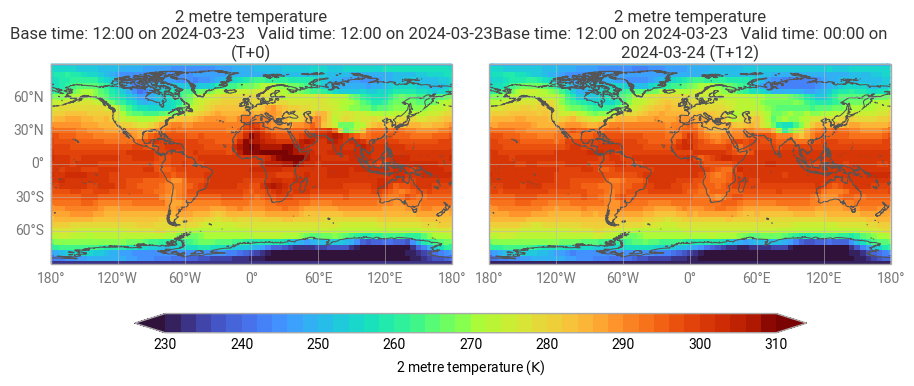

In [2]:
import earthkit.plots

figure = earthkit.plots.Figure(size=(9, 6), rows=1, columns=2)
figure.add_map().plot(r[0])
figure.add_map().plot(r[1])
figure.coastlines()
figure.subplot_titles()
figure.legend()
figure.gridlines(sharey=True)
figure.show()

#### Converting the results to xarray

In [3]:
r.to_xarray()

<xarray.Dataset> Size: 22kB
Dimensions:            (time: 1, step: 2, heightAboveGround: 1, latitude: 37,
                        longitude: 72)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-03-23T12:00:00
  * step               (step) timedelta64[ns] 16B 00:00:00 12:00:00
  * heightAboveGround  (heightAboveGround) float64 8B 2.0
  * latitude           (latitude) float64 296B 90.0 85.0 80.0 ... -85.0 -90.0
  * longitude          (longitude) float64 576B 0.0 5.0 10.0 ... 350.0 355.0
    valid_time         (time, step) datetime64[ns] 16B ...
Data variables:
    t2m                (time, step, heightAboveGround, latitude, longitude) float32 21kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-18T17:29 GRIB to CDM+CF via cfgrib-0.9.1...

#### Writing the results to disk

Write the resulting fieldlist to disk:

In [4]:
out_file = "_res_H8_nested_to_5x5.grib"
r.save(out_file)